# Reproduction notebook for the calculations and accompanying figures in "Radio detections of IR-selected runaway stellar bow shocks" by Van den Eijnden et al. (2022)

### Table of contents for this notebook:

- Step 0: Loading python packages and basic plotting settings
- Step 1: Loading the relevant input (both measured from RACS and taken from the E-BOSS catalogues) for all sources
- Step 2: Defining the relevant equations and constants for the thermal and non-thermal calculations
- Step 3: Plotting Figure 8: the injection efficiency as a function of magnetic field
- Step 4: Plotting Figure 9: the relation between electron temperature and density for detected sources:
- Step 5: Plotting Figure 10: predicted flux densities versus sensitivity for the thermal and non-thermal scenarios
- Step 6: Plotting Figure 12: comparing thermal and non-thermal flux densities for the non-detected sources in two scenarios

### This code uses the following python packages and versions:

numpy v1.15.4

matplotlib v2.2.3

aplpy v1.1.1

scipy v1.1.0

astropy v2.0.9

# Step 0: loading python packages and basic plotting settings

### Setting the path for the font to use in plotting labels and texts:

In [17]:
# Make sure to change this path to your local version, or otherwise comment out the noted line in the next cell
path = '/Library/Fonts/Arial Unicode.ttf'

### Loading the packages and setting up plots

In [18]:
import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as font_manager
import matplotlib.gridspec as gridspec
from matplotlib import colors
import aplpy

from scipy import interpolate
from scipy import optimize
from scipy.integrate import quad
import scipy.special

import os
from astropy import units as u
from astropy.io import fits
from astropy.units import cds
cds.enable()  

# If the font should not be changed, comment out the next two lines:
prop = font_manager.FontProperties(fname=path)
mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['pdf.fonttype']=42

params = {'text.usetex':False, 'mathtext.fontset':'custom', 'mathtext.default':'regular'}
mpl.rcParams.update(params)

single_col = 8.9 # cm
double_col = 18.33 # cm
def cm2inch(value):
    return value/2.54
FS = 22
LS = 22
MS = 14
MEW= 1.5

%matplotlib inline

# Step 1: Loading the relevant input (both measured from RACS and taken from the E-BOSS catalogues) for all sources

In [19]:
# Source names: the first column:
sources = np.genfromtxt('all_sources_info.txt', usecols=[0], unpack=True, dtype='str')

# All other paramaters: the remaining columns:
radio_detected, Snu, RACS_RMS, BMAJ, BMIN, d, v, mdot, l2, w2, R2, nism = np.genfromtxt('all_sources_info.txt', 
                                                                                        usecols=[1,2,3,4,5,6,7,8,9,10,11,12],
                                                                                        unpack=True)

# Converting the loaded quantities to the correct units:
Snu = Snu * u.microJansky
BMAJ = BMAJ * u.arcsecond
BMIN = BMIN * u.arcsecond
d = d * u.parsec
v = v * u.km / u.second
mdot = mdot * cds.Msun / u.year
l2 = l2 * u.parsec # the 2 is based on the E-BOSS notation and means in physical (not angular) units.
w2 = w2 * u.parsec # the 2 is based on the E-BOSS notation and means in physical (not angular) units.
R2 = R2 * u.parsec # the 2 is based on the E-BOSS notation and means in physical (not angular) units.
nism = nism * (u.cm**-3)

# Performing basic calculations with the data above, to determine the angular beam size, the physical size 
# that this corresponds to, and the volume assuming the depth equals the bow shock width. 
angular_beamsize = (np.pi * BMAJ * BMIN).to(u.radian**2)
physical_beamsize = angular_beamsize.value * (d**2)
physical_beamvolume = physical_beamsize * w2

# We also calculate the wind density at the bow shock stand-off distance, and the maximum magnetic field:
rho_wind = (mdot / (4.*np.pi*(R2**2)*v)).to(u.kg * u.cm**-3)
Bmax = ((2.0 * cds.mu0 * 0.75 * rho_wind * (v**2))**0.5).to(u.microGauss)

In [20]:
# Printing the source names
for i in xrange(len(sources)):
    print i+1, sources[i]

1 HIP16518
2 HIP24575
3 HIP25923
4 HIP26397
5 HIP29276
6 HIP31766
7 HIP32067
8 HIP34536
9 HIP38430
10 HIP62322
11 HIP72510
12 HIP75095
13 HIP77391
14 HIP78401
15 HIP81377
16 HIP82171
17 HIP88652
18 HIP92865
19 HIP97796
20 HIP47868
21 HIP98418
22 HIP104579
23 HD57682
24 HIP86768
25 RCW49-S1
26 K4
27 K5
28 K7
29 K10
30 G1
31 G2
32 G3
33 G4
34 G5
35 G6
36 G8
37 4U1907+09
38 J1117-6120
39 Star_1


Notice how there are 39 sources in this list, compared to 40 in the Appendix Table A1 in the paper. This is because Vela X-1 is left out of these calculations. 

# Step 2: Defining the relevant equations and constants for the thermal and non-thermal calculations

The parameters below are all used in the non-thermal calculations and are the 'default' values; when we deviate from these, the main paper explains why.

In [21]:
# The minimum and maximum assumed electron energy:
Emin = (cds.me * cds.c * cds.c).to(u.eV) * u.eV
Emax = 1e12 * u.eV

# The minimum considered magnetic field:
Bmin = 1 * u.microGauss

# The standard assumed alpha:
alpha = 0.5
p = 2*alpha + 1.0

# The maximum realistic assumed injection efficiency:
ETA = 0.1

Below, we define two functions for the non-thermal scenario: the constant $a(p)$ and the integral of energy from Equation (1) in the main paper.

In [22]:
def a_p(p):
    
    F1 = (np.pi**0.5)/(2.*(p+1.))
    F2 = scipy.special.gamma(p/4. + 19./12.)
    F3 = scipy.special.gamma(p/4. - 1./12.)
    F4 = scipy.special.gamma(p/4. + 5./4.)
    F5 = scipy.special.gamma(p/4. + 7./4.)
    
    return F1*F2*F3*F4/F5

def Integral(p, Emin, Emax):
    if p == 2.:
        ratio = (Emax.to(u.J)/Emin.to(u.J)).value
        return np.log(Emax/Emin)
    else:
        return ((1./(2.-p)) * (Emax**(2.-p) - Emin**(2.-p))).to(u.J**(2.-p))

Below, we define four functions: firstly, a function to calculate Equation (1) -- the injection efficiency -- from the main paper; secondly, an inverted version of this Equation to calculate the radio flux density, for a given injection efficiency; thirdly, the function to calculate the thermal radio flux density for a given temperature and density (see Van den Eijnden et al. (2022a) for a derivation of this equation); fourthly, the Gaunt factor.

In [23]:
def eta_e(B, p, R0, D, Snu_tot, Mdot, vwind, DR, Vbs, nu_obs, Emin, Emax):
    
    F1 = 128.*(np.pi**3)*(R0**3.)*(D**2.)*Snu_tot*cds.eps0*cds.c*cds.me
    F2 = (3.**1.5)*Mdot*vwind*DR*Vbs*(cds.e**3)*B*a_p(p)
    
    F12 = (F1/F2).to(u.J**-1)
        
    F3 = 3.*cds.e*B / (2.*np.pi*nu_obs*(cds.me**3)*(cds.c**4))    
    F3 = F3**(-1.*(p-1.)/2.)
    F3 = F3.to(u.J**(p-1.)) 
        
    F4 = Integral(p, Emin, Emax)
        
    try:
        return (F12*F3*F4).to(u.dimensionless_unscaled)
    except:
        return (F12*F3*F4).value
    
def S_nu_calc(B, p, R0, D, eta_e, Mdot, vwind, DR, Vbs, nu_obs, Emin, Emax):
    
    F1 = eta_e*(3.**1.5)*Mdot*vwind*DR*Vbs*(cds.e**3)*B*a_p(p)
    F2 = 128.*(np.pi**3)*(R0**3.)*(D**2.)*cds.eps0*cds.c*cds.me
    
    F12 = (F1/F2).to(u.milliJansky * u.J)
    
    F3 = 3.*cds.e*B / (2.*np.pi*nu_obs*(cds.me**3)*(cds.c**4)) 
    F3 = F3**(1.*(p-1.)/2.)
    F3 = F3.to(u.J**(1.-p)) 
    
    F4 = Integral(p, Emin, Emax)
    F4 = F4.to(u.J**(2.-p))
    
    try:
        return (F12*F3/F4).to(u.milliJansky)
    except:
        return (F12*F3/F4).value * u.milliJansky
    
def S_nu_thermal(n, T, nu, D, V):
    
    C_radio = 6.8e-38 * u.erg * u.cm**-3 * u.s**-1 * u.Hz**-1
    
    kappa_nu = C_radio * ((n.to(u.cm**-3).value)**2) * ((T.to(u.Kelvin).value)**(-0.5)) * gaunt(T=T, nu=nu, z=1)
    
    return (kappa_nu * V / (4*np.pi*(D**2))).to(u.milliJansky)

def gaunt(nu, T, z):
    # The Gaunt factor
        
    F1 = 128.*(cds.eps0**2)*(cds.k**3)*(T**3)
    F2 = cds.me * (cds.e**4)*(nu**2)*(z**2)
    
    G = (3**0.5 / (2.*np.pi)) * (np.log(F1/F2) - 0.5772156649)
    
    return G

# Step 3: Plotting Figure 8: the injection efficiency as a function of magnetic field

In [24]:
markers = ['r-', 'r--', 'r:', 'b-', 'b--', 'b:', 'g-', 'g--', 'g:']

HIP38430 322.834666969 uG 0.00809637088173
HIP88652 97.322145133 uG 0.0378746160055
HIP98418 307.795836513 uG 0.00287337542398
RCW49-S1 76.4120419437 uG 0.172985500516
K5 19.6101614373 uG 24.8005181172
G1 51.046723034 uG 0.823326831773
G3 57.5111599723 uG 0.144878631986


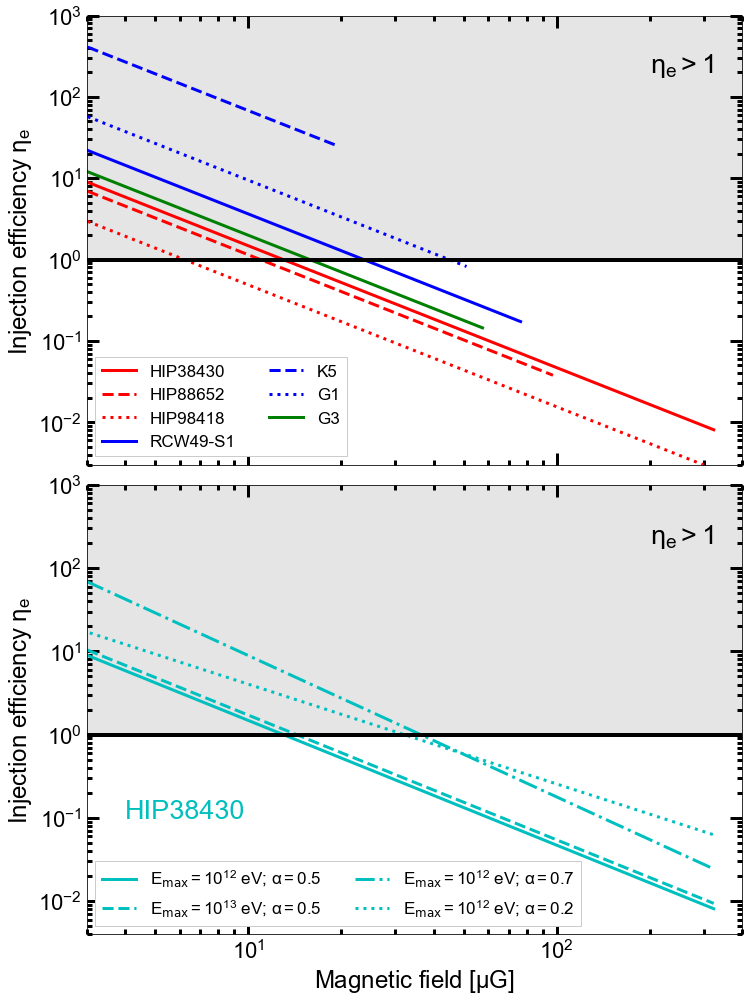

In [32]:
# Setting up the Figure and the top panel:
fig = plt.figure(figsize=(cm2inch(3*single_col),cm2inch(4*single_col)))
ax = fig.add_subplot(211)

ax.tick_params(labelsize=LS, width=3, length=12, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=5, width=3, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

# Looping over all sources to find those that are detected, and then plot their eta_e vs B:
j = 0 # Extra counter for the markers
for i in xrange(len(sources)):
    
    # Testing if the source is radio-detected:
    if radio_detected[i] == 1:
        index = i

        # Defining a magnetic field axis in the relevant range:
        B_axis = (10**np.linspace(-1, np.log10(Bmax[index].value), 1000, endpoint=True)) * u.microGauss

        # Calculating eta_e(B):
        eta_plot = eta_e(B=B_axis, p=p, R0=R2[index], D=d[index], Snu_tot=Snu[index], 
                 Mdot=mdot[index], vwind=v[index], DR=w2[index], Vbs=physical_beamvolume[index], 
                 nu_obs=887.5*u.MHz, Emin=Emin, Emax=Emax)

        # Printing the source name, maximum magnetic field, and minimum eta_e (i.e. eta_e(B_max))
        print sources[i], Bmax[i], min(eta_plot)
                
        # Plotting:    
        ax.plot(B_axis, eta_plot, markers[j], lw=3, label=sources[i])
        j = j+1

# Final touches to the panel:
ax.plot([1e-100, 1e100], [1., 1.], 'k-', lw=4)
ax.fill_between([1e-100, 1e100], [1., 1.], [1e100, 1e100], facecolor='k', alpha=0.1)
ax.text(200, 200, r'$\eta_e > 1$', fontsize=FS+5)

ax.set_xlim(3., 400) 
ax.set_ylim(0.003,1000.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticklabels([])

# Label and legend:
ax.set_ylabel(r'Injection efficiency $\eta_e$', fontsize=FS+2)
ax.legend(loc=3, frameon=True, framealpha=1, fancybox=False, shadow=False, ncol=2, fontsize=FS-5)

###################################################################################################################
# Second panel: setup
ax = fig.add_subplot(212)

ax.tick_params(labelsize=LS, width=3, length=12, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=5, width=3, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

# Setting the index to 8: HIP 38430 and defining the relevant B axis:
index = 8
B_axis = (10**np.linspace(-1, np.log10(Bmax[index].value), 1000, endpoint=True)) * u.microGauss

# Calculating eta_e for different values of alpha and Emax:
eta_plot = eta_e(B=B_axis, p=p, R0=R2[index], D=d[index], Snu_tot=Snu[index], 
                 Mdot=mdot[index], vwind=v[index], DR=w2[index], Vbs=physical_beamvolume[index], 
                 nu_obs=887.5*u.MHz, Emin=Emin, Emax=Emax)
ax.plot(B_axis, eta_plot, 'c-', lw=3, label=r'$E_{\rm max} = 10^{12}$ eV; $\alpha=0.5$')

eta_plot = eta_e(B=B_axis, p=p, R0=R2[index], D=d[index], Snu_tot=Snu[index], 
                 Mdot=mdot[index], vwind=v[index], DR=w2[index], Vbs=physical_beamvolume[index], 
                 nu_obs=887.5*u.MHz, Emin=Emin, Emax=1e13*u.eV)
ax.plot(B_axis, eta_plot, 'c--', lw=3, label=r'$E_{\rm max} = 10^{13}$ eV; $\alpha=0.5$')

eta_plot = eta_e(B=B_axis, p=2.4, R0=R2[index], D=d[index], Snu_tot=Snu[index], 
                 Mdot=mdot[index], vwind=v[index], DR=w2[index], Vbs=physical_beamvolume[index], 
                 nu_obs=887.5*u.MHz, Emin=Emin, Emax=1e12*u.eV)
ax.plot(B_axis, eta_plot, 'c-.', lw=3, label=r'$E_{\rm max} = 10^{12}$ eV; $\alpha=0.7$')

eta_plot = eta_e(B=B_axis, p=1.4, R0=R2[index], D=d[index], Snu_tot=Snu[index], 
                 Mdot=mdot[index], vwind=v[index], DR=w2[index], Vbs=physical_beamvolume[index], 
                 nu_obs=887.5*u.MHz, Emin=Emin, Emax=1e12*u.eV)
ax.plot(B_axis, eta_plot, 'c:', lw=3, label=r'$E_{\rm max} = 10^{12}$ eV; $\alpha=0.2$')

# Final details of plot setup:
ax.plot([1e-100, 1e100], [1., 1.], 'k-', lw=4)
ax.fill_between([1e-100, 1e100], [1., 1.], [1e100, 1e100], facecolor='k', alpha=0.1)
ax.text(200, 200, r'$\eta_e > 1$', fontsize=FS+5)
ax.text(4,0.1,'HIP38430',color='c', fontsize=FS+5)

ax.set_xlim(3., 400) 
ax.set_ylim(0.004,1000.)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Magnetic field [$\mu$G]', fontsize=FS+2)
ax.set_ylabel(r'Injection efficiency $\eta_e$', fontsize=FS+2)

ax.legend(loc=3, frameon=True, framealpha=1, fancybox=False, shadow=False, ncol=2, fontsize=FS-5)

# Saving:
plt.tight_layout()
plt.savefig('./Figure8/Figure8.png', dpi=500)

# Step 4: Plotting Figure 9: the relation between electron temperature and density for detected sources:

In [26]:
# Defining the temperature axis for the plot:
T_axis = 10**np.linspace(1, 8, 1000, endpoint=True) * u.Kelvin

In [27]:
# Defining the radio constant from Van den Eijnden et al. (2022a):
C_radio = 6.8e-38 * u.erg * u.cm**-3 * u.s**-1 * u.Hz**-1

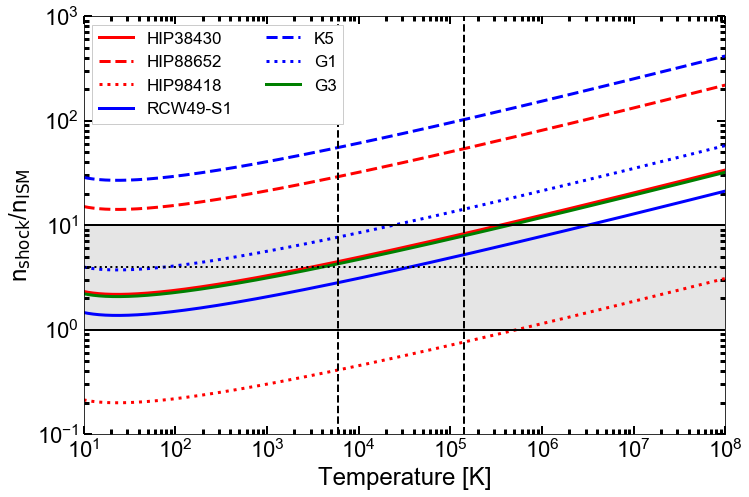

In [28]:
# Setting up the plot:
fig = plt.figure(figsize=(cm2inch(3*single_col),cm2inch(2*single_col)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=5, width=3, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

# Looping over the sources to plot those that are detected, with an extra counter for the markers:
j=0
for i in xrange(len(sources)):
    if radio_detected[i] == 1:
        index = i
        
        # Calculating n_e vs T for the given flux:
        kappa_nu = (4.*np.pi*(d[index]**2)*Snu[index]) / physical_beamvolume[index]
        n_e_squared = kappa_nu / (C_radio * (T_axis.value**-0.5) * gaunt(887.5*u.MHz, T_axis, z=1))

        n_e = (n_e_squared**0.5).to(u.dimensionless_unscaled) # units: cm^-3.

        # Plotting:
        ax.plot(T_axis, n_e / nism[index], markers[j], lw=3, label=sources[i])
        j=j+1
        
# Finalizing the plot setup:
ax.plot([1e-100, 1e100], [1., 1.], 'k-', lw=2)
ax.plot([1e-100, 1e100], [10., 10.], 'k-', lw=2)
ax.plot([1e-100, 1e100], [4., 4.], 'k:', lw=2)
ax.fill_between([1e-100, 1e100], [1., 1.], [10., 10.], facecolor='k', alpha=0.1)

ax.plot([6000,6000], [1e-100, 1e100], 'k--', lw=2)
ax.plot([1.4e5,1.4e5], [1e-100, 1e100], 'k--', lw=2)

ax.set_xlim(10., 1e8) 
ax.set_ylim(0.1,1e3)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Temperature [K]', fontsize=FS+2)
ax.set_ylabel(r'$n_{\rm shock}/ n_{\rm ISM}$', fontsize=FS+2)

ax.legend(loc=2, frameon=True, fancybox=False, shadow=False, ncol=2, fontsize=FS-5, framealpha=1)

# Saving:
plt.tight_layout()
plt.savefig('./Figure9/Figure9.png', dpi=500)

# Step 5: Plotting Figure 10: predicted flux densities versus sensitivity for the thermal and non-thermal scenarios

HIP75095 0.75 mJy 2.143007716 mJy
HIP77391 0.6 mJy 1.99598196787 mJy
HD57682 1.29 mJy 22.4910014667 mJy
K7 4.83 mJy 8.27782363037 mJy
G4 2.34 mJy 7.01690577361 mJy


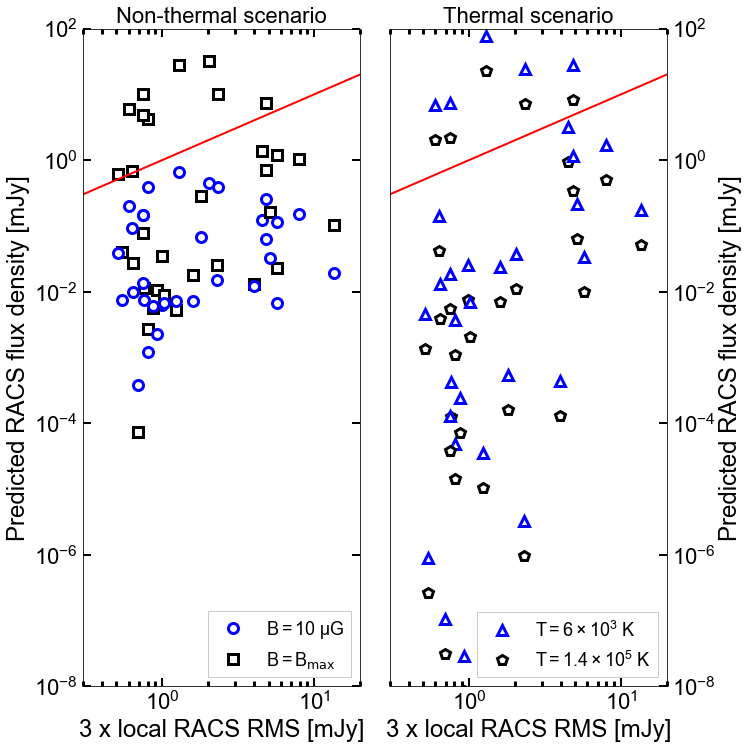

In [29]:
# Setting up the figure and the left panel:
fig = plt.figure(figsize=(cm2inch(3*single_col),cm2inch(3*single_col)))
ax = fig.add_subplot(121)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=5, width=3, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

# The non-thermal calculations: 
# Loop over the non-detected sources; for each, calculate the predicted flux density at 10 uG and the maximum 
# magnetic field, assuming eta_e = 0.1. Plot it against 3 times the local RMS.
Blow = 10.*u.microGauss
for i in xrange(len(sources)):
    
    if radio_detected[i] == 0:
        index = i

        Bhigh = Bmax[index]
     
        Snu_plot = S_nu_calc(B=Bhigh, p=p, R0=R2[index], D=d[index], eta_e=0.1, 
                 Mdot=mdot[index], vwind=v[index], DR=w2[index], Vbs=physical_beamvolume[index], 
                 nu_obs=887.5*u.MHz, Emin=Emin, Emax=Emax)

        ax.plot(3*Snu[index]/1000., Snu_plot, 'ws', ms=10, mew=3, mec='k')
        
        Snu_plot = S_nu_calc(B=Blow, p=p, R0=R2[index], D=d[index], eta_e=0.1, 
                 Mdot=mdot[index], vwind=v[index], DR=w2[index], Vbs=physical_beamvolume[index], 
                 nu_obs=887.5*u.MHz, Emin=Emin, Emax=Emax)

        ax.plot(3*Snu[index]/1000., Snu_plot, 'wo', ms=10, mew=3, mec='b')
        
# Defining the markers for the legend:
ax.plot([],[], 'wo', ms=10, mew=3, mec='b', label=r'$B=10$ $\mu$G')
ax.plot([],[], 'ws', ms=10, mew=3, mec='k', label=r'$B=B_{\rm max}$')

# Final panel setup:
ax.plot([1e-100,1e100], [1e-100,1e100], 'r-', lw=2)

ax.set_xlim(3e-1, 2e1) 
ax.set_ylim(1e-8, 1e2)
ax.set_xscale('log')
ax.set_yscale('log')

# Labels, legend, and title:
ax.set_xlabel(r'3 x local RACS RMS [mJy]', fontsize=FS+2)
ax.set_ylabel(r'Predicted RACS flux density [mJy]', fontsize=FS+2)

ax.legend(loc=4, frameon=True, fancybox=False, shadow=False, ncol=1, fontsize=FS-4, framealpha=1)

ax.set_title('Non-thermal scenario', fontsize=FS)

########################################################################################################
# Setting up the right panel:
ax = fig.add_subplot(122)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=5, width=3, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

# The thermal scenario: calculate the thermal flux density for two temperatures and an overdensity of 4. 
for i in xrange(len(sources)):
    
    if radio_detected[i] == 0:
        index = i
        
        Snu_plot = S_nu_thermal(n=nism[index]*4, T=1.4e5*u.Kelvin, nu=887.5*u.MHz, 
                                D=d[index], V=physical_beamvolume[index])

        ax.plot(3*Snu[index]/1000., Snu_plot, 'wp', ms=10, mew=3, mec='k')
        
        # Print the names, RMS, and predicted flux density of the sources that would have been detected:
        if (3*Snu[index]).to(u.milliJansky) < Snu_plot:
            print sources[index], (3*Snu[index]).to(u.milliJansky), Snu_plot
            
        Snu_plot = S_nu_thermal(n=nism[index]*4, T=6e3*u.Kelvin, nu=887.5*u.MHz, 
                                D=d[index], V=physical_beamvolume[index])

        ax.plot(3*Snu[index]/1000., Snu_plot, 'w^', ms=10, mew=3, mec='b')
        
# Defining the markers for the legend:
ax.plot([],[], 'w^', ms=10, mew=3, mec='b', label=r'$T=6\times10^3$ K')
ax.plot([],[], 'wp', ms=10, mew=3, mec='k', label=r'$T=1.4\times10^5$ K')

# Final panel setup:
ax.plot([1e-100,1e100], [1e-100,1e100], 'r-', lw=2)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_yticks(10**np.linspace(-8,2,11), minor=False)

ax.set_xlim(3e-1, 2e1) 
ax.set_ylim(1e-8, 1e2)
ax.set_xscale('log')
ax.set_yscale('log')

# Labels, legend, and title:
ax.set_xlabel(r'3 x local RACS RMS [mJy]', fontsize=FS+2)
ax.set_ylabel(r'Predicted RACS flux density [mJy]', fontsize=FS+2)

ax.legend(loc=4, frameon=True, fancybox=False, shadow=False, ncol=1, fontsize=FS-4, framealpha=1)

ax.set_title('Thermal scenario', fontsize=FS)

# Saving the figure:
plt.tight_layout()
plt.savefig('./Figure10/Figure10.png', dpi=500)

# Step 6: Plotting Figure 12: comparing thermal and non-thermal flux densities for the non-detected sources in two scenarios

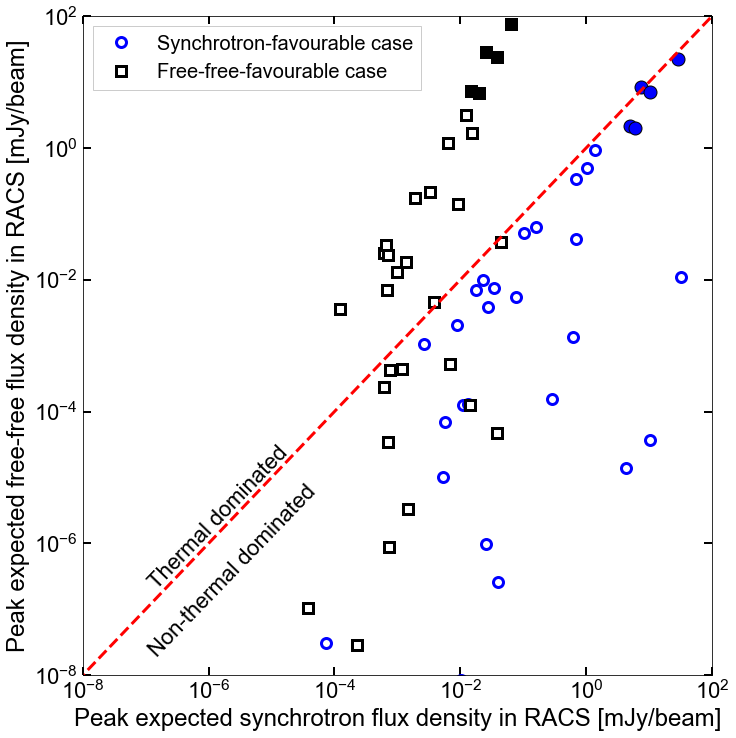

In [31]:
# Defining the figure and setting it up:
fig = plt.figure(figsize=(cm2inch(3*single_col),cm2inch(3*single_col)))
ax = fig.add_subplot(111)

ax.tick_params(labelsize=LS, width=2, length=8, axis='both', which='major', pad=5)
ax.tick_params(labelsize=LS, length=5, width=3, axis='both', which='minor', pad=5)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

# We will again loop over all sources and only consider those that are not detected.
# We assume two scenario, defined in the text. The minimum B field is 10 uG. 
Blow = 10.*u.microGauss
for i in xrange(len(sources)):
    
    if radio_detected[i] == 0:
        index = i

        Bhigh = Bmax[index]
     
        # Calculating the non-thermal (NT) and thermal (T) flux densities for the thermal scenario:
        Snu_plot_NT = S_nu_calc(B=Blow, p=p, R0=R2[index], D=d[index], eta_e=0.01, 
                 Mdot=mdot[index], vwind=v[index], DR=w2[index], Vbs=physical_beamvolume[index], 
                 nu_obs=887.5*u.MHz, Emin=Emin, Emax=Emax)
        
        Snu_plot_T = S_nu_thermal(n=nism[index]*4, T=6e3*u.Kelvin, nu=887.5*u.MHz, 
                                D=d[index], V=physical_beamvolume[index])
        
        # Plotting these two against each other, with a marker depending on whether we expected a detection
        # in Figure 10 -- thermal case with low T. 
        if sources[index] in ['HIP75095', 'HIP77391','HD57682','K7','G4']:
            ax.plot(Snu_plot_NT, Snu_plot_T, 'ks', ms=10, mec='k', mew=3)
        else:
            ax.plot(Snu_plot_NT, Snu_plot_T, 'ws', ms=10, mec='k', mew=3)
        
        # Calculating the non-thermal (NT) and thermal (T) flux densities for the non-thermal scenario:
        Snu_plot_NT = S_nu_calc(B=Bhigh, p=p, R0=R2[index], D=d[index], eta_e=0.1, 
                 Mdot=mdot[index], vwind=v[index], DR=w2[index], Vbs=physical_beamvolume[index], 
                 nu_obs=887.5*u.MHz, Emin=Emin, Emax=Emax)
        
        Snu_plot_T = S_nu_thermal(n=nism[index]*4, T=1.4e5*u.Kelvin, nu=887.5*u.MHz, 
                                D=d[index], V=physical_beamvolume[index])
        
        # Plotting these two against each other, with a marker depending on whether we expected a detection
        # in Figure 10 -- thermal case with low T. 
        if sources[index] in ['HIP75095', 'HIP77391','HD57682','K7','G4']:
            ax.plot(Snu_plot_NT, Snu_plot_T, 'bo', ms=13, mec='k', mew=1)
        else:
            ax.plot(Snu_plot_NT, Snu_plot_T, 'wo', ms=10, mec='b', mew=3)

# Finish the setup of the plot:
ax.plot([1e-100,1e100], [1e-100,1e100], 'r--', lw=3)
ax.text(1e-7, 2e-5, 'Thermal dominated', fontsize=FS, rotation=46)
ax.text(1e-7, 5e-6, 'Non-thermal dominated', fontsize=FS, rotation=46)

# Defining the markers:
ax.plot([],[], 'wo', ms=10, mew=3, mec='b', label=r'Synchrotron-favourable case')
ax.plot([],[], 'ws', ms=10, mew=3, mec='k', label=r'Free-free-favourable case')

ax.set_xlim(1e-8, 1e2) 
ax.set_ylim(1e-8, 1e2)
ax.set_xscale('log')
ax.set_yscale('log')

# Labels and legends:
ax.set_xlabel(r'Peak expected synchrotron flux density in RACS [mJy/beam]', fontsize=FS+2)
ax.set_ylabel(r'Peak expected free-free flux density in RACS [mJy/beam]', fontsize=FS+2)

ax.legend(loc=2, frameon=True, fancybox=False, shadow=False, ncol=1, fontsize=FS-2, framealpha=1)

# Saving:
plt.tight_layout()
plt.savefig('./Figure12/Figure12.png', dpi=500)